In [51]:
import numpy as np
from batchgenerators.utilities.file_and_folder_operations import *
import SimpleITK as sitk
import nibabel as nib
import skimage
import matplotlib.pyplot as plt

base_path = "C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/"
brats_folder_with_training_data_2020 = f"{base_path}MICCAI_BraTS2020_TrainingData/"
brats_folder_with_validation_data_2020 = f"{base_path}MICCAI_BraTS2020_ValidationData/"
training_data_path = brats_folder_with_training_data_2020
validation_data_path = brats_folder_with_validation_data_2020

In [4]:
from jonas_net import AlbuNet3D34

net = AlbuNet3D34(num_classes=4, pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\JiachennCJC/.cache\torch\checkpoints\resnet34-333f7ec4.pth


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [52]:
def get_list_of_files_2020(base_dir):
    """
    returns a list of lists containing the filenames. The outer list contains all training examples. Each entry in the
    outer list is again a list pointing to the files of that training example in the following order:
    T1, T1c, T2, FLAIR, segmentation
    :param base_dir:
    :return:
    """
    list_of_lists = []
    # current_directory = join(base_dir, glioma_type)
    current_directory = base_dir
    print("Current dir: ",current_directory)
    patients = subfolders(current_directory, join=False)
    for p in patients:
        patient_directory = join(current_directory, p)
        t1_file = join(patient_directory, p + "_t1.nii.gz")
        t1c_file = join(patient_directory, p + "_t1ce.nii.gz")
        t2_file = join(patient_directory, p + "_t2.nii.gz")
        flair_file = join(patient_directory, p + "_flair.nii.gz")
        seg_file = join(patient_directory, p + "_seg.nii.gz")
        this_case = [t1_file, t1c_file, t2_file, flair_file, seg_file]
        # this_case = [t1_file, t1c_file, t2_file, flair_file]
        assert all((isfile(i) for i in this_case)), "some file is missing for patient %s; make sure the following " \
                                                    "files are there: %s" % (p, str(this_case))
        list_of_lists.append(this_case)
    print("Found %d patients" % len(list_of_lists))
    return list_of_lists

def get_list_of_files_2020_val(base_dir):
    """
    returns a list of lists containing the filenames. The outer list contains all training examples. Each entry in the
    outer list is again a list pointing to the files of that training example in the following order:
    T1, T1c, T2, FLAIR, segmentation
    :param base_dir:
    :return:
    """
    list_of_lists = []
    # current_directory = join(base_dir, glioma_type)
    current_directory = base_dir
    print("Current dir: ",current_directory)
    patients = subfolders(current_directory, join=False)
    for p in patients:
        patient_directory = join(current_directory, p)
        t1_file = join(patient_directory, p + "_t1.nii.gz")
        t1c_file = join(patient_directory, p + "_t1ce.nii.gz")
        t2_file = join(patient_directory, p + "_t2.nii.gz")
        flair_file = join(patient_directory, p + "_flair.nii.gz")
#         seg_file = join(patient_directory, p + "_seg.nii.gz")
#         this_case = [t1_file, t1c_file, t2_file, flair_file, seg_file]
        this_case = [t1_file, t1c_file, t2_file, flair_file]
        assert all((isfile(i) for i in this_case)), "some file is missing for patient %s; make sure the following " \
                                                    "files are there: %s" % (p, str(this_case))
        list_of_lists.append(this_case)
    print("Found %d patients" % len(list_of_lists))
    return list_of_lists

def load_and_preprocess_UPDATED2020(case, patient_name, output_folder):

    print("Using the new preprocess thingy")
    # print("in patient name: ", patient_name)
    # print("in output folder: ", output_folder)
    """
    loads, preprocesses and saves a case
    This is what happens here:
    1) load all images and stack them to a 4d array
    2) crop to nonzero region, this removes unnecessary zero-valued regions and reduces computation time
    3) normalize the nonzero region with its mean and standard deviation
    4) save 4d tensor as numpy array. Also save metadata required to create niftis again (required for export
    of predictions)

    :param case:
    :param patient_name:
    :return:
    """
    # load SimpleITK Images
    imgs_sitk = [sitk.ReadImage(i) for i in case]

    # get pixel arrays from SimpleITK images
    imgs_npy = [sitk.GetArrayFromImage(i) for i in imgs_sitk]

    # get some metadata
    spacing = imgs_sitk[0].GetSpacing()
    # the spacing returned by SimpleITK is in inverse order relative to the numpy array we receive. If we wanted to
    # resample the data and if the spacing was not isotropic (in BraTS all cases have already been resampled to 1x1x1mm
    # by the organizers) then we need to pay attention here. Therefore we bring the spacing into the correct order so
    # that spacing[0] actually corresponds to the spacing of the first axis of the numpy array
    spacing = np.array(spacing)[::-1]

    direction = imgs_sitk[0].GetDirection()
    origin = imgs_sitk[0].GetOrigin()

    original_shape = imgs_npy[0].shape

    # now stack the images into one 4d array, cast to float because we will get rounding problems if we don't
    imgs_npy = np.concatenate([i[None] for i in imgs_npy]).astype(np.float32)

    # now find the nonzero region and crop to that
    nonzero = [np.array(np.where(i != 0)) for i in imgs_npy]
    nonzero = [[np.min(i, 1), np.max(i, 1)] for i in nonzero]
    nonzero = np.array([np.min([i[0] for i in nonzero], 0), np.max([i[1] for i in nonzero], 0)]).T
    # nonzero now has shape 3, 2. It contains the (min, max) coordinate of nonzero voxels for each axis

    # now crop to nonzero
    imgs_npy = imgs_npy[:,
               nonzero[0, 0] : nonzero[0, 1] + 1,
               nonzero[1, 0]: nonzero[1, 1] + 1,
               nonzero[2, 0]: nonzero[2, 1] + 1,
               ]

    # now we create a brain mask that we use for normalization
    nonzero_masks = [i != 0 for i in imgs_npy[:-1]]
    brain_mask = np.zeros(imgs_npy.shape[1:], dtype=bool)
    for i in range(len(nonzero_masks)):
        brain_mask = brain_mask | nonzero_masks[i]

    # now normalize each modality with its mean and standard deviation (computed within the brain mask)
    for i in range(len(imgs_npy) - 1):
        mean = imgs_npy[i][brain_mask].mean()
        std = imgs_npy[i][brain_mask].std()
        imgs_npy[i] = (imgs_npy[i] - mean) / (std + 1e-8)
        imgs_npy[i][brain_mask == 0] = 0

    # the segmentation of brats has the values 0, 1, 2 and 4. This is pretty inconvenient to say the least.
    # We move everything that is 4 to 3
    imgs_npy[-1][imgs_npy[-1] == 4] = 3

    # now save as npz
    np.save(join(output_folder, patient_name + ".npy"), imgs_npy)
    # print("Output folder end: ", join(output_folder, patient_name + ".npy"))
    # print("\n")


    metadata = {
        'spacing': spacing,
        'direction': direction,
        'origin': origin,
        'original_shape': original_shape,
        'nonzero_region': nonzero
    }

    save_pickle(metadata, join(output_folder, patient_name + ".pkl"))

    
def predict_patient_in_patches(patient_data, model):
    # we pad the patient data in order to fit the patches in it
    patient_data_pd = pad_nd_image(patient_data, [144, 192, 192]) # 24*6, 128+2*32, 128+2*32
    # patches.shape = (1, 1, 6, 3, 3, 1, 3, 24, 128, 128)
    steps = (1,1,args.patch_depth,int(args.patch_width/4),int(args.patch_height/4))
    window_shape = (1, 3, args.patch_depth, args.patch_width, args.patch_height)
    patches = skimage.util.view_as_windows(patient_data_pd[:, :3, :, :, :], window_shape=window_shape, step=steps)
    
    # (1, 4, 138, 169, 141)
    target_shape = list(patient_data_pd.shape)
    print(f"Target shape in predict patient in patches is: {target_shape}")

    if args.multi_class:
        target_shape[1] = 4
    else:
        target_shape[1] = 1 # only one output channel
    prediction = torch.zeros(*target_shape)
    if args.use_gpu:
        prediction = prediction.cuda()
    
    for i in range(patches.shape[2]):
        for j in range(patches.shape[3]):
            for k in range(patches.shape[4]):
                data = torch.from_numpy(patches[0, 0, i, j, k])
                if args.use_gpu:
                    data = data.cuda()
                output = model.forward(data)

                prediction[:, :,
                           i*steps[2]:i*steps[2]+window_shape[2],
                           j*steps[3]:j*steps[3]+window_shape[3],
                           k*steps[4]:k*steps[4]+window_shape[4]] += output
                    
    return prediction

In [53]:
patient_folders_train = get_list_of_files_2020(brats_folder_with_training_data_2020)
patient_folders_validation = get_list_of_files_2020_val(brats_folder_with_validation_data_2020)
patient_names_train = [i[0].split('\\')[-2] for i in patient_folders_train] 
patient_names_valid = [i[0].split('\\')[-2] for i in patient_folders_validation] 

Current dir:  C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_TrainingData/
Found 369 patients
Current dir:  C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_ValidationData/
Found 125 patients


In [33]:
case = patient_folders_train[0:2]
case[0]

['C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001\\BraTS20_Training_001_t1.nii.gz',
 'C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001\\BraTS20_Training_001_t1ce.nii.gz',
 'C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001\\BraTS20_Training_001_t2.nii.gz',
 'C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001\\BraTS20_Training_001_flair.nii.gz',
 'C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001\\BraTS20_Training_001_seg.nii.gz']

In [14]:
case = patient_folders_validation[0:2]
case[0]

['C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_001\\BraTS20_Validation_001_t1.nii.gz',
 'C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_001\\BraTS20_Validation_001_t1ce.nii.gz',
 'C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_001\\BraTS20_Validation_001_t2.nii.gz',
 'C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_001\\BraTS20_Validation_001_flair.nii.gz']

In [66]:
# Training data read
test = sitk.ReadImage(case[0])
test_np_array = sitk.GetArrayFromImage(test)

test_np_array = np.concatenate([i[None] for i in test_np_array]).astype(np.float32)
print(test_np_array.shape)
print(test_np_array[-1].shape)
print(test_np_array[-1].dtype)

(5, 155, 240, 240)
(155, 240, 240)
float32


In [79]:
test = np.zeros([240,240,155],dtype="float32")
test.shape
img = nib.Nifti1Image(test, np.eye(4))
img.get_fdata().shape
nib.save(img, "TESTINGDUMMYSEG.nii.gz")

In [136]:
nib.load("TESTINGDUMMYSEG.nii.gz").get_fdata().shape
dummy_img = sitk.GetArrayFromImage(sitk.ReadImage("TESTINGDUMMYSEG.nii.gz"))
dummy_img.shape

(155, 240, 240)

In [191]:
import nibabel as nib 
pat305 = nib.load("MICCAI_BraTS2020_TrainingData/BraTS20_Training_305/BraTS20_Training_305_seg.nii.gz").get_fdata()
print([np.array(np.where(i == 0)) for i in test_np_array])

[array([[  0,   0,   0, ..., 154, 154, 154],
       [  0,   0,   0, ..., 239, 239, 239],
       [  0,   1,   2, ..., 237, 238, 239]], dtype=int64), array([[  0,   0,   0, ..., 154, 154, 154],
       [  0,   0,   0, ..., 239, 239, 239],
       [  0,   1,   2, ..., 237, 238, 239]], dtype=int64), array([[  0,   0,   0, ..., 154, 154, 154],
       [  0,   0,   0, ..., 239, 239, 239],
       [  0,   1,   2, ..., 237, 238, 239]], dtype=int64), array([[  0,   0,   0, ..., 154, 154, 154],
       [  0,   0,   0, ..., 239, 239, 239],
       [  0,   1,   2, ..., 237, 238, 239]], dtype=int64), array([[  0,   0,   0, ..., 154, 154, 154],
       [  0,   0,   0, ..., 239, 239, 239],
       [  0,   1,   2, ..., 237, 238, 239]], dtype=int64)]


In [202]:
np.nonzero(pat305)[1]

array([91, 91, 91, ..., 99, 91, 92], dtype=int64)

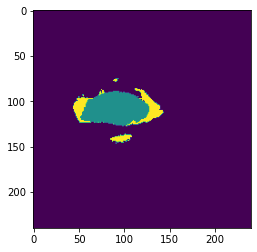

In [169]:
import matplotlib.pyplot as plt

plt.imshow(pat305[:,:,97])

In [45]:
model_folder = "20210311-070028_brats20_3d_pretrained_trainbatchsize_200_lr_0.001_epochs_50_epochbatch_200_epoch_30"
test = sitk.ReadImage(f"segmentation_output/Wrong Preprocessing Seg Output/{model_folder}/Brats20ValidationData/BraTS20_Validation_061.nii.gz")
new = sitk.GetArrayFromImage(test)
print(np.unique(new))
print(new.shape)

[0 1 2 4]
(155, 240, 240)


In [46]:
model_folder = "20210309-133958_brats20_3d_pretrained_new_lr_1_lr_0.0001_epochs_60_TESTINGONTRAINING_40"
test = sitk.ReadImage(f"segmentation_output/Wrong Preprocessing Seg Output/{model_folder}/Brats20TrainingData/BraTS20_Training_061.nii.gz")
new = sitk.GetArrayFromImage(test)
print(np.unique(new))
print(new.shape)

[0 1 2 4]
(155, 240, 240)


In [79]:
model_folder="20210321-070858_brats20_3d_small_training_2_lr_0.0001_epochs_70_epochbatch_75_epoch_UPGRADEDTRAININGDUMMY_10"
test = sitk.ReadImage(f"segmentation_output/{model_folder}/Brats20TrainingData/BraTS20_Training_301.nii.gz")
new = sitk.GetArrayFromImage(test)
print(np.unique(new))
print(new.shape)

[0 1 2 4]
(155, 240, 240)


In [82]:
new.nonzero()

(array([ 45,  45,  45, ..., 133, 133, 133], dtype=int64),
 array([109, 110, 110, ..., 131, 131, 135], dtype=int64),
 array([139, 138, 142, ..., 137, 139, 143], dtype=int64))

In [77]:
model_folder = "20210321-095418_brats20_3d_pretrained_trainbatchsize_100_2_lr_0.0001_epochs_50_epochbatch_100_epoch_UPDATEDVALIDATION_30"
test = sitk.ReadImage(f"segmentation_output/{model_folder}/Brats20ValidationData/BraTS20_Validation_076.nii.gz")
new = sitk.GetArrayFromImage(test)
print(np.unique(new))
print(new.shape)

[0 1 2 4]
(155, 240, 240)


In [78]:
test = sitk.ReadImage("segmentation_output/20210321-095418_brats20_3d_pretrained_trainbatchsize_100_2_lr_0.0001_epochs_50_epochbatch_100_epoch_UPDATEDVALIDATION_30/Brats20ValidationData/BraTS20_Validation_001.nii.gz")
new = sitk.GetArrayFromImage(test)
print(np.unique(new))
print(new.shape)

[0 1 2 4]
(155, 240, 240)


In [83]:
model_folder = "20210309-021115_brats20_3d_pretrained_new_1_lr_0.01_epochs_60_40"
test = sitk.ReadImage(f"segmentation_output/Wrong Preprocessing Seg Output/{model_folder}/Brats20ValidationData/BraTS20_Validation_061.nii.gz")
new = sitk.GetArrayFromImage(test)
print(np.unique(new))
print(new.shape)

[0 1 2 4]
(155, 240, 240)


In [23]:
new.shape

(155, 240, 240)

In [ ]:
new

In [22]:
np.unique(new)

array([0, 1, 2, 4], dtype=uint8)

In [20]:
np.unique(new)

array([0, 1, 2, 4], dtype=uint8)

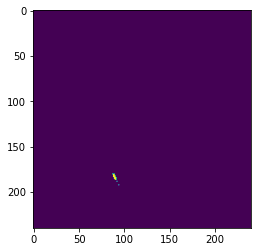

In [28]:
plt.imshow(new[65,:,:])

In [185]:
test = np.ones([240,240,155],dtype="float32")

In [133]:
# Try to create dummy files lmao
brats_folder_with_dummy_data_2020 = f"{base_path}MICCAI_BraTS2020_TrainingData_DUMMY/"
 
list_of_patients = get_list_of_files_2020(brats_folder_with_dummy_data_2020)
patient_names_training = [i[0].split('/')[-1].split('\\')[0] for i in list_of_patients] 
patient_names_validation = [i[0].split('/')[-1].split('\\')[0] for i in patient_folders_validation] 

# patient_names_training = patient_names_training[0:5]

for i in patient_names_training:
    test = np.ones([240,240,155],dtype="float32")
    img = nib.Nifti1Image(test, np.eye(4))
#     nib.save(img, f"{brats_folder_with_dummy_data_2020}"+f"{i}/"+ f"{i}_segUPDATE.nii.gz")

sitk.GetArrayFromImage(sitk.ReadImage(brats_folder_with_dummy_data_2020 + "BraTS20_Training_301/BraTS20_Training_301_segUPDATE.nii.gz")).shape

Current dir:  C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_TrainingData_DUMMY/
Found 69 patients


In [16]:
# Validation data read
test = sitk.ReadImage(case[0])
sitk.GetArrayFromImage(test).shape

(4, 155, 240, 240)

In [60]:
short_list = patient_folders_train[0:2]
case = short_list[1]
case

['C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002\\BraTS20_Training_002_t1.nii.gz',
 'C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002\\BraTS20_Training_002_t1ce.nii.gz',
 'C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002\\BraTS20_Training_002_t2.nii.gz',
 'C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002\\BraTS20_Training_002_flair.nii.gz',
 'C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002\\BraTS20_Training_002_seg.nii.gz']

In [61]:
imgs_sitk = [sitk.ReadImage(i) for i in case]

imgs_npy = [sitk.GetArrayFromImage(i) for i in imgs_sitk]

# get some metadata
spacing = imgs_sitk[0].GetSpacing()

# the spacing returned by SimpleITK is in inverse order relative to the numpy array we receive. If we wanted to
# resample the data and if the spacing was not isotropic (in BraTS all cases have already been resampled to 1x1x1mm
# by the organizers) then we need to pay attention here. Therefore we bring the spacing into the correct order so
# that spacing[0] actually corresponds to the spacing of the first axis of the numpy array
spacing = np.array(spacing)[::-1]

direction = imgs_sitk[0].GetDirection()
origin = imgs_sitk[0].GetOrigin()

original_shape = imgs_npy[0].shape
print(f"Original shape is: {original_shape}")

imgs_npy = np.concatenate([i[None] for i in imgs_npy]).astype(np.float32)
print(f"After concat shape is: {imgs_npy.shape}")

# now find the nonzero region and crop to that
nonzero = [np.array(np.where(i != 0)) for i in imgs_npy]
nonzero = [[np.min(i, 1), np.max(i, 1)] for i in nonzero]
nonzero = np.array([np.min([i[0] for i in nonzero], 0), np.max([i[1] for i in nonzero], 0)]).T
print(f"Nonzero shape is {nonzero.shape}")
print(f"Nonzero value is {nonzero}")
# nonzero now has shape 3, 2. It contains the (min, max) coordinate of nonzero voxels for each axis

# now crop to nonzero, note that this applies the crop to all channels (t1,t1ce,flair,etc)
imgs_npy = imgs_npy[:,
           nonzero[0, 0] : nonzero[0, 1] + 1,
           nonzero[1, 0]: nonzero[1, 1] + 1,
           nonzero[2, 0]: nonzero[2, 1] + 1,
           ]
print(f"After cropping nonzero shape is : {imgs_npy.shape}")

# now we create a brain mask that we use for normalization 
# this excludes the seg mask since imgs_npy[:-1] means its not covered
nonzero_masks = [i != 0 for i in imgs_npy[:-1]]
brain_mask = np.zeros(imgs_npy.shape[1:], dtype=bool)

print(f"Brain mask shape: {brain_mask.shape}")

for i in range(len(nonzero_masks)):
    brain_mask = brain_mask | nonzero_masks[i]
    
# now normalize each modality with its mean and standard deviation (computed within the brain mask)
# This also excludes normalizing the last element of the list (seg if 5 files)
for i in range(len(imgs_npy) - 1):
    print(i)
    mean = imgs_npy[i][brain_mask].mean()
    std = imgs_npy[i][brain_mask].std()
    imgs_npy[i] = (imgs_npy[i] - mean) / (std + 1e-8)
    imgs_npy[i][brain_mask == 0] = 0

print(f"Imgs npy after normalizing: {imgs_npy.shape}")


Original shape is: (155, 240, 240)
After concat shape is: (5, 155, 240, 240)
Nonzero shape is (3, 2)
Nonzero value is [[  0 139]
 [ 31 217]
 [ 53 186]]
After cropping nonzero shape is : (5, 140, 187, 134)
Brain mask shape: (140, 187, 134)
0
1
2
3
Imgs npy after normalizing: (5, 140, 187, 134)


In [73]:
imgs_npy[-1][imgs_npy[-1]==3]=4

In [75]:
imgs_npy[-1][imgs_npy[-1]==4]

array([4., 4., 4., ..., 4., 4., 4.], dtype=float32)

In [70]:
np.unique(imgs_npy[-1])

array([0., 1., 2., 3.], dtype=float32)

In [276]:
for i in range(len(imgs_npy)):
    print(i)
    mean = imgs_npy[i][brain_mask].mean()
    std = imgs_npy[i][brain_mask].std()
    imgs_npy[i] = (imgs_npy[i] - mean) / (std + 1e-8)
    imgs_npy[i][brain_mask == 0] = 0

0
1
2
3
4


In [275]:
len(imgs_npy)

5

In [266]:
imgs_npy.nonzero()

(array([0, 0, 0, ..., 4, 4, 4], dtype=int64),
 array([  0,   0,   0, ..., 108, 108, 108], dtype=int64),
 array([105, 106, 106, ...,  87,  88,  88], dtype=int64),
 array([72, 69, 70, ..., 53, 52, 53], dtype=int64))

In [272]:
np.arange(10)[:-1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [253]:
imgs_npy[:-1].shape

(4, 135, 173, 137)

In [51]:
from brats_data_loader import *

patdata, metadata = BRATSDataLoader.load_patient("brats_data_preprocessed/Brats20ValidationData/BraTS20_Validation_001")

In [152]:
patdata, metadata = BRATSDataLoader.load_patient("brats_data_preprocessed/Brats20TrainingData/BraTS20_Training_001")
print(patdata.shape, metadata)
print([np.array(np.where(i != 0)) for i in test_np_array])

(4, 135, 173, 137) {'spacing': array([1., 1., 1.]), 'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), 'origin': (-0.0, -239.0, 0.0), 'original_shape': (155, 240, 240), 'nonzero_region': array([[  4, 138],
       [ 42, 214],
       [ 49, 185]], dtype=int64)}
[array([[  4,   4,   4, ..., 138, 138, 138],
       [147, 148, 148, ..., 124, 124, 125],
       [121, 118, 119, ..., 131, 132, 131]], dtype=int64), array([[  4,   4,   4, ..., 138, 138, 138],
       [147, 148, 148, ..., 124, 124, 125],
       [121, 118, 119, ..., 131, 132, 131]], dtype=int64), array([[  4,   4,   4, ..., 138, 138, 138],
       [147, 148, 148, ..., 124, 124, 125],
       [121, 118, 119, ..., 131, 132, 131]], dtype=int64), array([[  4,   4,   4, ..., 138, 138, 138],
       [147, 148, 148, ..., 124, 124, 125],
       [121, 118, 119, ..., 131, 132, 131]], dtype=int64), array([[ 30,  30,  30, ..., 112, 112, 112],
       [107, 107, 108, ..., 129, 130, 130],
       [ 93,  94,  93, ..., 102, 101, 102]], dtype=int6

In [ ]:
# def load_and_preprocess_UPDATED2020(case, patient_name, output_folder):
"""
loads, preprocesses and saves a case
This is what happens here:
1) load all images and stack them to a 4d array
2) crop to nonzero region, this removes unnecessary zero-valued regions and reduces computation time
3) normalize the nonzero region with its mean and standard deviation
4) save 4d tensor as numpy array. Also save metadata required to create niftis again (required for export
of predictions)

:param case: list of lists of directory
:param patient_name: list of patient name (strings)
:return:
"""
# load SimpleITK Images
imgs_sitk = [sitk.ReadImage(i) for i in case]

# get pixel arrays from SimpleITK images
imgs_npy = [sitk.GetArrayFromImage(i) for i in imgs_sitk]

# get some metadata
spacing = imgs_sitk[0].GetSpacing()
# the spacing returned by SimpleITK is in inverse order relative to the numpy array we receive. If we wanted to
# resample the data and if the spacing was not isotropic (in BraTS all cases have already been resampled to 1x1x1mm
# by the organizers) then we need to pay attention here. Therefore we bring the spacing into the correct order so
# that spacing[0] actually corresponds to the spacing of the first axis of the numpy array
spacing = np.array(spacing)[::-1]

direction = imgs_sitk[0].GetDirection()
origin = imgs_sitk[0].GetOrigin()

original_shape = imgs_npy[0].shape

# now stack the images into one 4d array, cast to float because we will get rounding problems if we don't
imgs_npy = np.concatenate([i[None] for i in imgs_npy]).astype(np.float32)

# now find the nonzero region and crop to that
nonzero = [np.array(np.where(i != 0)) for i in imgs_npy]
nonzero = [[np.min(i, 1), np.max(i, 1)] for i in nonzero]
nonzero = np.array([np.min([i[0] for i in nonzero], 0), np.max([i[1] for i in nonzero], 0)]).T
# nonzero now has shape 3, 2. It contains the (min, max) coordinate of nonzero voxels for each axis

# now crop to nonzero
imgs_npy = imgs_npy[:,
           nonzero[0, 0] : nonzero[0, 1] + 1,
           nonzero[1, 0]: nonzero[1, 1] + 1,
           nonzero[2, 0]: nonzero[2, 1] + 1,
           ]

# now we create a brain mask that we use for normalization
nonzero_masks = [i != 0 for i in imgs_npy[:-1]]
brain_mask = np.zeros(imgs_npy.shape[1:], dtype=bool)
for i in range(len(nonzero_masks)):
    brain_mask = brain_mask | nonzero_masks[i]

# now normalize each modality with its mean and standard deviation (computed within the brain mask)
for i in range(len(imgs_npy) - 1):
    mean = imgs_npy[i][brain_mask].mean()
    std = imgs_npy[i][brain_mask].std()
    imgs_npy[i] = (imgs_npy[i] - mean) / (std + 1e-8)
    imgs_npy[i][brain_mask == 0] = 0

# the segmentation of brats has the values 0, 1, 2 and 4. This is pretty inconvenient to say the least.
# We move everything that is 4 to 3
imgs_npy[-1][imgs_npy[-1] == 4] = 3

# now save as npz
# np.save(join(output_folder, patient_name + ".npy"), imgs_npy)
# print("Output folder end: ", join(output_folder, patient_name + ".npy"))
# print("\n")


metadata = {
    'spacing': spacing,
    'direction': direction,
    'origin': origin,
    'original_shape': original_shape,
    'nonzero_region': nonzero
}

# save_pickle(metadata, join(output_folder, patient_name + ".pkl"))
